In [1]:
import wrds
import pandas as pd
import datetime

In [5]:
# Load the data from CSV files
beta_df = pd.read_csv('beta_df.csv')
beta_df['Ticker'] = beta_df['Ticker'].astype(int)
FundRatios = pd.read_csv('Final.csv')

# Convert datadate to datetime and extract the year
FundRatios['datadate'] = pd.to_datetime(FundRatios['datadate']).dt.year
FundRatios['Year'] = FundRatios['datadate']
FundRatios['Ticker'] = FundRatios['gvkey']

# Sort DataFrame by Ticker and datadate
FundRatios = FundRatios.sort_values(by=['Ticker', 'datadate'])

# Drop unnecessary columns
columns_to_drop = ['datadate', 'gvkey', 'indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'LINKTYPE', 'MthCalDt', 'LPERMNO']
FundRatios.drop(columns_to_drop, axis=1, inplace=True)

# Create lagged columns and fill NaN values with zero
lag_columns = ['invt', 'ap', 'at', 'rectr']
for col in lag_columns:
    FundRatios[f'lag_{col}'] = FundRatios.groupby('Ticker')[col].shift(1)
    FundRatios[f'lag_{col}'] = FundRatios[f'lag_{col}'].fillna(0)

# Calculate additional columns
FundRatios['TDTA'] = FundRatios['lt'] / FundRatios['at']
FundRatios['AP_TOV'] = FundRatios['cogs'] + (FundRatios['invt'] - FundRatios['lag_invt']) / ((FundRatios['ap'] + FundRatios['lag_ap']) / 2)
FundRatios['Inv_TOV'] = FundRatios['cogs'] / ((FundRatios['invt'] + FundRatios['lag_invt']) / 2)
FundRatios['change_in_ebitda'] = FundRatios.groupby('Ticker')['ebitda'].diff()
FundRatios['change_in_sales'] = FundRatios.groupby('Ticker')['sale'].diff()
FundRatios['ol'] = FundRatios['change_in_ebitda'] / FundRatios['change_in_sales']
FundRatios['ol'] = FundRatios['ol'].fillna(0)
FundRatios['AR_TOV'] = FundRatios['revt'] / ((FundRatios['rectr'] + FundRatios['lag_rectr']) / 2)
FundRatios['ROA'] = FundRatios['oiadp'] / ((FundRatios['at'] + FundRatios['lag_at']) / 2)
FundRatios['CFM'] = FundRatios['oancf'] / FundRatios['revt']
FundRatios['GPM'] = FundRatios['gp'] / FundRatios['revt']
FundRatios['btm'] = FundRatios['oancf'] / (FundRatios['prcl_f'] + ((FundRatios['prch_f'] - FundRatios['prcl_f']) / 2))

# Merge DataFrames
dfmerge = pd.merge(FundRatios, beta_df, on=['Year', 'Ticker'])
dfmerge = dfmerge.dropna(subset=['Year', 'Ticker','TDTA', 'AP_TOV', 'Inv_TOV', 'ol', 'AR_TOV', 'ROA', 'CFM','btm','GPM','Beta'])

# Reset index
dfmerge.reset_index(drop=True, inplace=True)

print(dfmerge)

         tic       ap         at  bkvlps      cogs    ebitda        gp  \
0     ADCT.1  211.300   3970.500  3.7813  1567.100   670.100  1720.800   
1     ADCT.1  162.000   2499.700  2.3907  1484.200   -55.600   918.600   
2     ADCT.1   73.000   1144.200  0.9157   677.600  -192.400   370.100   
3     ADCT.1   49.300   1296.900  0.7782   422.600    19.900   350.600   
4     ADCT.1   72.800   1428.100  0.8139   440.700    78.200   343.600   
...      ...      ...        ...     ...       ...       ...       ...   
3315    ATVI  302.000  13742.000  8.6018  1646.000  1091.000  2633.000   
3316    ATVI  363.000  13406.000  8.6224  1606.000  1318.000  2841.000   
3317    VRSK   51.982   1217.090 -0.6729   463.473   508.496   674.870   
3318    AVGO  198.000   2157.000  6.2738   988.000   629.000  1105.000   
3319    FTNT   12.761    545.422  3.1252    79.510    61.037   245.186   

         invt        lt     oancf  ...    Inv_TOV  change_in_ebitda  \
0     486.100  1057.800   221.400  ...  

In [6]:
filtered_df = dfmerge.groupby('Ticker').filter(lambda x: len(x) == 10)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 551 to 3174
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tic               180 non-null    object 
 1   ap                180 non-null    float64
 2   at                180 non-null    float64
 3   bkvlps            178 non-null    float64
 4   cogs              180 non-null    float64
 5   ebitda            180 non-null    float64
 6   gp                180 non-null    float64
 7   invt              180 non-null    float64
 8   lt                180 non-null    float64
 9   oancf             180 non-null    float64
 10  oiadp             180 non-null    float64
 11  rectr             180 non-null    float64
 12  revt              180 non-null    float64
 13  sale              180 non-null    float64
 14  costat            180 non-null    object 
 15  prch_f            180 non-null    float64
 16  prcl_f            180 non-null    float64
 17 

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df[numeric_columns].dropna(inplace=True)
    indices_to_keep = ~df[numeric_columns].isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[numeric_columns][indices_to_keep].astype(np.float64)

filtered_df_c=clean_dataset(filtered_df)

Mean Squared Error: 0.10875808360438911
R-squared: -0.46
          Coefficient
Ticker   3.473133e-06
Year    -3.661073e-03
TDTA    -5.067999e-02
AP_TOV   4.953307e-07
Inv_TOV -1.997522e-03
ol       2.214939e-02
AR_TOV   3.630241e-03
ROA     -6.981965e-01
CFM     -2.110151e-01
btm      1.024804e-04
GPM      2.299244e-01


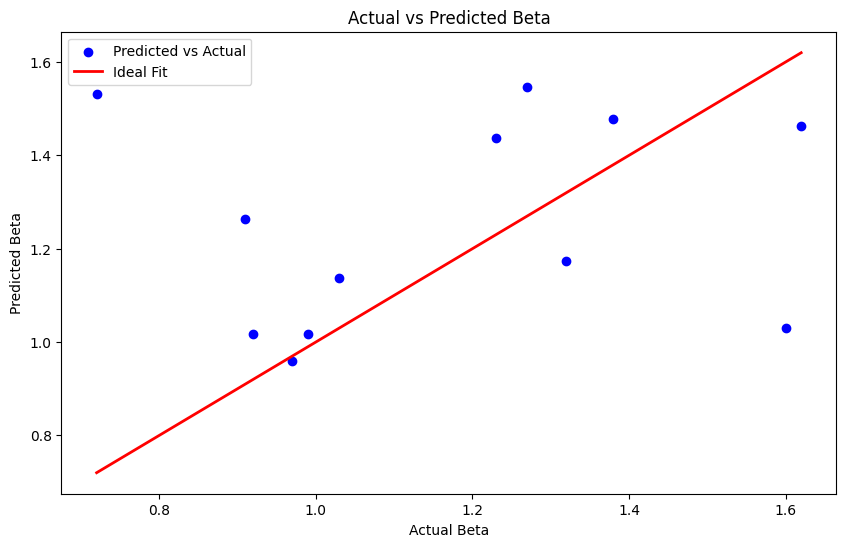

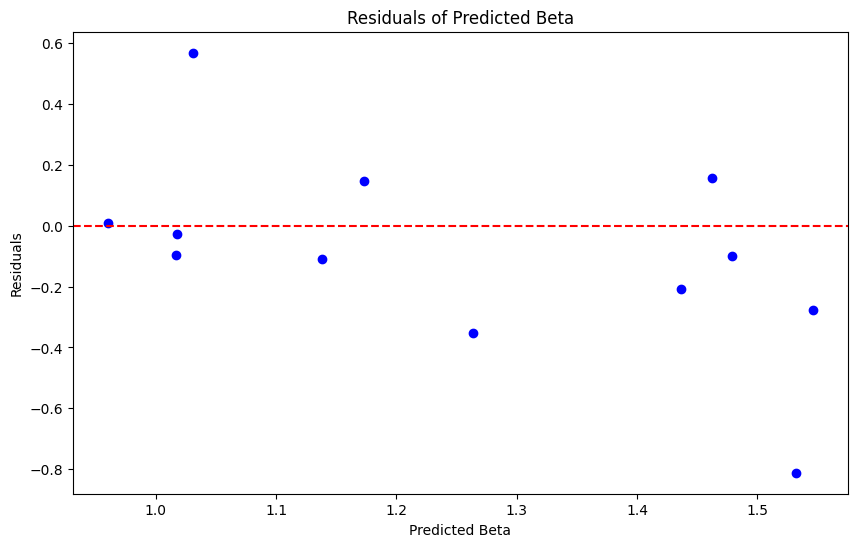

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Split the data into training and testing sets based on the year
train_df = filtered_df_c[filtered_df_c['Year'] <= 2009]
test_df = filtered_df_c[filtered_df_c['Year'] == 2010]

# Define the features (X) and target (y)
X_train = train_df[['Ticker','Year','TDTA', 'AP_TOV', 'Inv_TOV', 'ol', 'AR_TOV', 'ROA', 'CFM','btm','GPM']]
y_train = train_df['Beta']

X_test = test_df[['Ticker','Year','TDTA', 'AP_TOV', 'Inv_TOV', 'ol', 'AR_TOV', 'ROA', 'CFM','btm','GPM']]
y_test = test_df['Beta']

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate and print R-squared
r_squared = model.score(X_test, y_test)
print(f"R-squared: {r_squared:.2f}")

# Print the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print(coefficients)

# Visualization of the model showing the error of the predicted beta
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Beta')
plt.ylabel('Predicted Beta')
plt.title('Actual vs Predicted Beta')
plt.legend()
plt.show()

# Plotting the residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Beta')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted Beta')
plt.show()